In [128]:
import numpy as np
from scipy.optimize import minimize_scalar
import pandas as pd
import matplotlib.pyplot as plt

## Shaping Gain

### Funções para cálculo de entropia e energia média

In [129]:
# Cálculo da entropia dos símbolos
def entropy(p):
    return -np.sum(p * np.log2(p + 1e-12))  # adiciona termo pequeno p evitar log(0)

# Cálculo da energia média do símbolo
def average_energy(p, A_M):
    return np.sum(p * np.abs(A_M)**2)

# gerar M-ay PAM
def PAM(M):
    A = []
    for i in range(0, M):
        A_i = -(M-1) + 2*i
        A.append(A_i)
    return A



### Cálculos para distribuição não uniforme

In [130]:
M = 8
A_M = PAM(M)
print(f"A_{M} = {A_M}")

# calcula vetor de variáveis não ótimas
p = [i for i in range(M)]
p = np.array([val / sum(p) for val in p])
print("p = ", p)

#cálculo da entropia e energia média
H_p = entropy(p)
print(f"H(p) = {H_p}")

E_p = average_energy(p, A_M)
print(f"E(p) = {E_p}")

A_8 = [-7, -5, -3, -1, 1, 3, 5, 7]
p =  [0.         0.03571429 0.07142857 0.10714286 0.14285714 0.17857143
 0.21428571 0.25      ]
H(p) = 2.6100053707857036
E(p) = 21.0


### Cálculo do ganho

In [131]:
# Shaping Gain
M_linha = 2**H_p
print(f"M_linha = {M_linha}")
E_M_linha = average_energy(p[0:int(M_linha)], A_M[0:int(M_linha)])  # energia média para símbolos equiprováveis
Gs_p = E_M_linha/E_p
print(f"G_s(p) = {Gs_p}")

M_linha = 6.1050595633797
G_s(p) = 0.16156462585034012


In [132]:
Gs_p_ = ((2**(2*H_p)) - 1)/ (3*E_p)
print(f"G_s(p) = {Gs_p_}")

G_s(p) = 0.575742099562126


### Cálculos para distribuiçao uniforme

In [133]:
# teste para síbolos equiprováveis
p_eq = np.array([1/M for _ in range(M)])
print("p_eq = ", p_eq)

H_p_eq = entropy(p_eq)
print(f"H(p_eq) = {H_p_eq}")

E_p_eq = average_energy(p_eq, A_M)
print(f"E(p_eq) = {E_p_eq}")

E_M = (M**2 -1)/3
print(f"E(p) = E_M = {E_M}")

p_eq =  [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
H(p_eq) = 2.9999999999884586
E(p_eq) = 21.0
E(p) = E_M = 21.0


### Otimização do vetor de probabilidade

In [134]:

def compute_alpha(s, A_M):
    return 1.0 / np.sum(np.exp(-s * np.abs(A_M)**2))

def compute_probabilities(s, A_M):
    alpha = compute_alpha(s, A_M)
    return alpha * np.exp(-s * np.abs(A_M)**2)

def optimize_for_entropy(A_M, R_target, bounds=(1e-5, 5)):
    def objective(s):
        p = compute_probabilities(s, A_M)
        H = entropy(p)
        return (H - R_target)**2

    result = minimize_scalar(objective, bounds=bounds, method='bounded')
    s_opt = result.x
    alpha_opt = compute_alpha(s_opt, A_M)
    p_opt = compute_probabilities(s_opt, A_M)
    
    return s_opt, alpha_opt, p_opt, entropy(p_opt), average_energy(p_opt, A_M)

def optimize_for_energy(A_M, S_target, bounds=(1e-5, 5)):
    def objective(s):
        p = compute_probabilities(s, A_M)
        S = average_energy(p, A_M)
        return (S - S_target)**2

    result = minimize_scalar(objective, bounds=bounds, method='bounded')
    s_opt = result.x
    alpha_opt = compute_alpha(s_opt, A_M)
    p_opt = compute_probabilities(s_opt, A_M)
    
    return s_opt, alpha_opt, p_opt, entropy(p_opt), average_energy(p_opt, A_M)


In [135]:
M = 8
A_M = PAM(M)
R_target = np.log2(M) * 0.99     
S_target = (pow(M,2)-1)/3                  

print(f"A_M = {A_M}")

# Otimizar para entropia
s_e, alpha_e, p_e, H_e, E_e = optimize_for_entropy(A_M, R_target)
print(f"\nPara entropia desejada < que {R_target:.4f}")
print(f"s = {s_e:.4f}, alpha = {alpha_e:.4f}")
print(f"Entropia = {H_e:.4f}, Energia média = {E_e:.4f}")
print(f"Probabilidades: {p_e}")

# Otimizar para energia
s_s, alpha_s, p_s, H_s, E_s = optimize_for_energy(A_M, S_target)
print(f"\nPara energia média desejada < que {S_target:.4f}")
print(f"s = {s_s:.4f}, alpha = {alpha_s:.4f}")
print(f"Entropia = {H_s:.4f}, Energia média = {E_s:.4f}")
print(f"Probabilidades: {p_s}")

A_M = [-7, -5, -3, -1, 1, 3, 5, 7]

Para entropia desejada < que 2.9700
s = 0.0116, alpha = 0.1561
Entropia = 2.9700, Energia média = 17.3354
Probabilidades: [0.08834934 0.1167551  0.1406018  0.15429377 0.15429377 0.1406018
 0.1167551  0.08834934]

Para energia média desejada < que 21.0000
s = 0.0000, alpha = 0.1250
Entropia = 3.0000, Energia média = 20.9954
Probabilidades: [0.12495205 0.12499314 0.12502055 0.12503426 0.12503426 0.12502055
 0.12499314 0.12495205]


## Huffman Shaping

In [136]:
# Métricas
def average_code_rate(M, K, L):
    """
    Calcula a taxa média de codificação.
    
    M: número de símbolos
    K: número de bits por símbolo
    L: lista de comprimentos dos códigos para cada símbolo
    """
    return sum(2**(-L[i]) * L[i] for i in range(M)) / K

def standard_deviation_rate(M, K, L, R_h):
    """
    Calcula o desvio padrão da taxa de codificação.
    
    M: número de símbolos
    K: número de bits por símbolo
    L: lista de comprimentos dos códigos para cada símbolo
    R_h: taxa média de codificação
    """
    return np.sqrt(sum(2**(-L[i]) * (L[i] - K*R_h)**2 for i in range(M)) / K)

def average_energy_dimension(A_M, L, K):
    """
    Calcula a dimensão de energia.
    
    A_M: constelação
    L: lista de comprimentos dos códigos para cada símbolo
    K: número de bits por símbolo
    """
    return sum(2**(-L[i]) * np.abs(A_M[i])**2 for i in range(len(A_M))) / K

def shaping_gain(R_h, E_h):
    """
    Calcula o ganho de shaping.
    
    R_h: taxa média de codificação
    E_h: energia média do código
    """
    return ((2**(2*R_h)) - 1) / (3 * E_h)

In [137]:
# Huffman shaping algorithm
def huffman_shaping(A_M, p):
    """
    Implementa o algoritmo de Huffman shaping.
    
    A_M: constelação
    p: vetor de probabilidades
    """
    # Implementação do algoritmo de Huffman shaping
    # (a ser implementado conforme necessário)
    pass
        

### Otimização 128-QAM primeiro quadrante
Reprodução do livro

In [138]:
def generate_qam_closest_to_origin(M):
    """
    Gera uma constelação QAM no primeiro quadrante com pontos próximos da origem,
    selecionando os pontos com menor distância.

    Parâmetros:
    ----------
    M : int
        Número total de pontos na constelação (incluindo todos os quadrantes).

    Retorno:
    -------
    np.array
        Pontos da constelação QAM no primeiro quadrante como números complexos.
    """
    # Número de pontos no primeiro quadrante
    points_per_quadrant = M // 4

    # Calcula o maior quadrado perfeito próximo
    side_length = int(np.ceil(np.sqrt(points_per_quadrant)))

    # Inicializa a lista de pontos
    qam_points = []

    # Gera os pontos no primeiro quadrante
    for i_1 in range(side_length):
        for i_2 in range(side_length):
            if len(qam_points) < M:  # Adiciona pontos até atingir M
                real = 1 + 2 * i_1  # Coordenada real
                imag = 1 + 2 * i_2  # Coordenada imaginária
                qam_points.append(complex(real, imag))  # Adiciona o ponto como número complexo

    # Calcula a distância de cada ponto para a origem
    distances = np.array([np.abs(p) for p in qam_points])

    # Ordena os pontos pela distância à origem
    sorted_indices = np.argsort(distances)
    qam_points_sorted = np.array(qam_points)[sorted_indices]

    # Retorna apenas os pontos mais próximos da origem
    return qam_points_sorted[:points_per_quadrant]

def plot_qam_constellation(qam_points):
    """
    Plota a constelação QAM no plano complexo.

    Parâmetros:
    ----------
    qam_points : np.array
        Pontos da constelação QAM como números complexos.
    """
    # Extrai as partes real e imaginária dos pontos
    real = np.real(qam_points)
    imag = np.imag(qam_points)

    # Cria o gráfico
    plt.figure(figsize=(5, 5))
    plt.scatter(real, imag, color='blue', s=50, label='Pontos da constelação')
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.title("Constelação QAM no Primeiro Quadrante (Próxima da Origem)", fontsize=10)
    plt.xlabel("Parte Real", fontsize=8)
    plt.ylabel("Parte Imaginária", fontsize=8)
    plt.axis('equal')  # Garante que os eixos tenham a mesma escala
    plt.show()

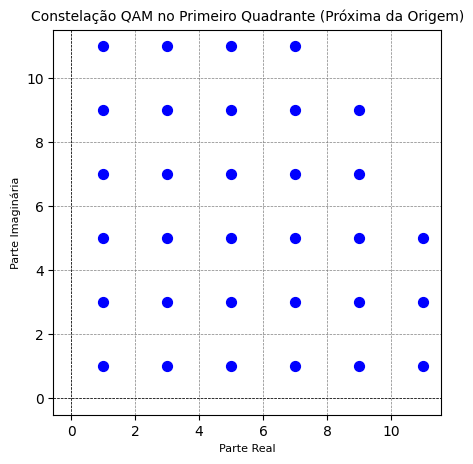

In [139]:
# Exemplo de uso
M = 128  # Número total de pontos na constelação
qam_closest = generate_qam_closest_to_origin(M)  # Gera os pontos da constelação
plot_qam_constellation(qam_closest)  # Plota a constelação

In [140]:
R_target = 2.975   
# Otimizar para entropia
s_e, alpha_e, p_e, H_e, E_e = optimize_for_entropy(qam_closest, R_target, (1e-5, 5))
print(f"\nPara entropia desejada < que {R_target:.4f}")
print(f"s = {s_e:.4f}, alpha = {alpha_e:.4f}")
print(f"Entropia = {H_e:.4f}, Energia média = {E_e:.4f}")
df = pd.DataFrame({'QAM': qam_closest, 'abs(QAM)**2': np.abs(qam_closest)**2, 'P': np.round(p_e, 5), "-log2(P)": -np.log2(p_e)})



Para entropia desejada < que 2.9750
s = 0.0679, alpha = 0.3457
Entropia = 2.9750, Energia média = 14.7317


In [141]:
df

,QAM,abs(QAM)**2,P,-log2(P)
0,1.0+ 1.0j,2.0,0.30178,1.728418
1,1.0+ 3.0j,10.0,0.17535,2.511723
2,3.0+ 1.0j,10.0,0.17535,2.511723
3,3.0+ 3.0j,18.0,0.10188,3.295029
4,1.0+ 5.0j,26.0,0.05920,4.078334
5,5.0+ 1.0j,26.0,0.05920,4.078334
6,5.0+ 3.0j,34.0,0.03440,4.861639
7,3.0+ 5.0j,34.0,0.03440,4.861639
8,7.0+ 1.0j,50.0,0.01161,6.428250
9,5.0+ 5.0j,50.0,0.01161,6.428250


### Teste com dados do artigo

In [142]:
p_i = [
    0.03872, 0.02991, 0.02991, 0.02311, 0.01785, 0.01785,
    0.01379, 0.01379, 0.01379, 0.00823, 0.00823, 0.00823,
    0.00636, 0.00636, 0.00379, 0.00379, 0.00379, 0.00293,
    0.00293, 0.00226, 0.00226, 0.00175, 0.00135, 0.00135,
    0.00135, 0.00081, 0.00081, 0.00062, 0.00062, 0.00062,
    0.00062, 0.00037, 0.00037, 0.00022, 0.00017
]


In [145]:
np.round(-np.log2(p_i))

array([ 5.,  5.,  5.,  5.,  6.,  6.,  6.,  6.,  6.,  7.,  7.,  7.,  7.,
        7.,  8.,  8.,  8.,  8.,  8.,  9.,  9.,  9., 10., 10., 10., 10.,
       10., 11., 11., 11., 11., 11., 11., 12., 13.])

In [144]:
l_i = np.round(-np.log2(p_i))
np.sum((2**(-l_i)))

0.2757568359375

In [147]:
-np.log2(0.00024)

12.024677973715656